In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-08-17 13:53:55.139803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 13:53:55.139836: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'Patch-Seq'
modality_names = ['Gene Expression', 'EPhys']
human_cells = pd.read_csv("../data/patchseq_human_L23/human_IVSCC_excitatory_L23_consolidated_0131.csv", index_col=0)
human_morph = pd.read_csv("../data/patchseq_human_L23/All_L23_Lockdown_all_raw_features.csv", index_col=0)
ephys = pd.read_csv("../data/patchseq_human_L23/human_mouse_ephys_all_0127.csv", index_col=0)
sample_names = list(set(human_cells.index) & set(human_morph.index) & set(ephys.index))
data1 = human_morph.loc[sample_names]
data2 = ephys.loc[sample_names]
type1 = type2 = np.array(human_cells.loc[sample_names]['contaminationType'])  # medical_conditions, contaminationType

# Labels
labels = [type1, type2]
features = [None, None]

# Preprocessing
data1 = np.nan_to_num(preprocessing.scale(data1, axis=0))
data2 = np.nan_to_num(preprocessing.scale(data2, axis=0))
dataset = [data1, data2]

# Utility
positivize = lambda X: [x + x.min() for x in X]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 50
pca_dim = None
dist_method = 'euclidean'

# ComManDo

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.4074 alpha:0.5585
epoch:[1000/2000] err:0.3769 alpha:0.5754
epoch:[1500/2000] err:0.3589 alpha:0.5865
epoch:[2000/2000] err:0.3369 alpha:0.5959
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.077434
epoch:[1000/2000]: loss:0.839684
epoch:[1500/2000]: loss:0.810429
epoch:[2000/2000]: loss:0.794566
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.02270652598235756
Correspondence: 0.72684850305086
Mapping: 21.08969720301684
Total: 21.839252232050058

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.091045
epoch:[1000/2000]: loss:0.874603
epoch:[1500/2000]: loss:0.797069
epoch:[2000/2000]: 

In [8]:
# Imputation
cm = ComManDo(**kwargs)
cm.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (82, 60)
Dataset 1: (82, 18)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.3826 alpha:0.4736
epoch:[1000/2000] err:0.3580 alpha:0.4862
epoch:[1500/2000] err:0.3460 alpha:0.4944
epoch:[2000/2000] err:0.3412 alpha:0.4991
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.106456
epoch:[1000/2000]: loss:0.873777
epoch:[1500/2000]: loss:0.810295
epoch:[2000/2000]: loss:0.788317
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.02290676604025066
Correspondence: 0.5641820000018924
Mapping: 12.712002445012331
Total: 13.299091211054474



# Comparison Methods

In [9]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [10]:
# MMD-MA
from sklearn.metrics import pairwise_distances
mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)

# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)

2022-08-17 13:55:15.016475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 13:55:15.016505: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 13:55:15.016516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2022-08-17 13:55:15.016666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:0.4004 alpha:0.5030
epoch:[200/2000] err:0.4219 alpha:0.5390
epoch:[300/2000] err:0.4202 alpha:0.5480
epoch:[400/2000] err:0.4146 alpha:0.5538
epoch:[500/2000] err:0.4075 alpha:0.5584
epoch:[600/2000] err:0.4002 alpha:0.5625
epoch:[700/2000] err:0.3933 alpha:0.5662
epoch:[800/2000] err:0.3872 alpha:0.5695
epoch:[900/2000] err:0.3817 alpha:0.5726
epoch:[1000/2000] err:0.3769 alpha:0.5754
epoch:[1100/2000] err:0.3727 alpha:0.5780
epoch:[1200/2000] err:0.3689 alpha:0.5803
epoch:[1300/2000] err:0.3655 alpha:0.5825
epoch:[1400/2000] err:0.3622 alpha:0.5846
epoch:[1500/2000] err:0.3589 alpha:0.5865
epoch:[1600/2000] err:0.3556 alpha:0.5884
epoch:[1700/2000] err:0.3519 alpha:0.5902
epoch:[1800/2000] err:0.3478 alpha:0.5920
epoch:[1900/2000] err:0.3429 alpha:0.5939
epoch:[2000/2000] err:0.3370

In [11]:
# NN
nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [12]:
integrated_data = [cm_data, nlma_data, lma_data, cca_data, mmd_ma_data, uc_data]
integrated_names = ['JAMIE', 'Nonlinear\nManifold\nAlignment', 'Linear\nManifold\nAlignment', 'CCA', 'MMD-MA', 'Unioncom']
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', 'NN'][::-1]
colors = ['blue', 'red', 'green', 'm', 'yellow', 'teal']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 18})

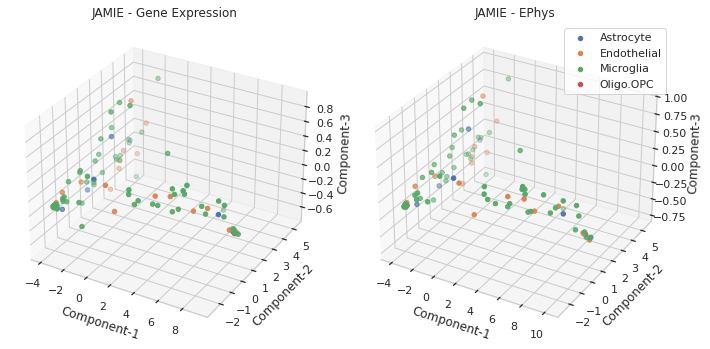

In [13]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

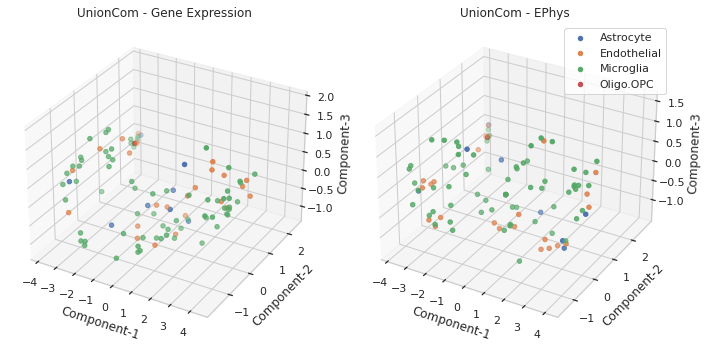

In [14]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(uc_data, labels, ['UnionCom - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-UnionCom.png')

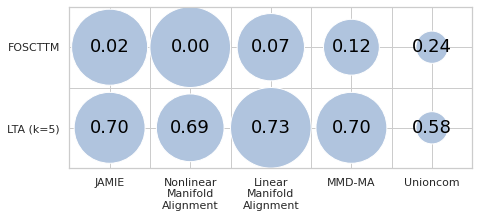

In [15]:
plt.figure(figsize=(7, 5))
plot_accuracy_table(integrated_data, labels, integrated_names, exclude=[3])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

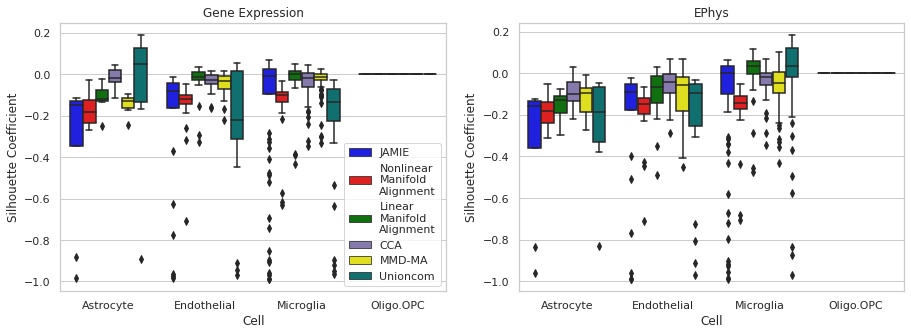

In [16]:
plt.figure(figsize=(13, 5))
plot_silhouette(integrated_data, labels, integrated_names, modality_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

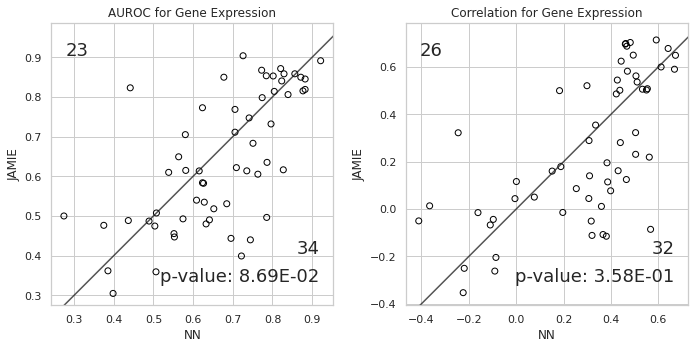

In [17]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

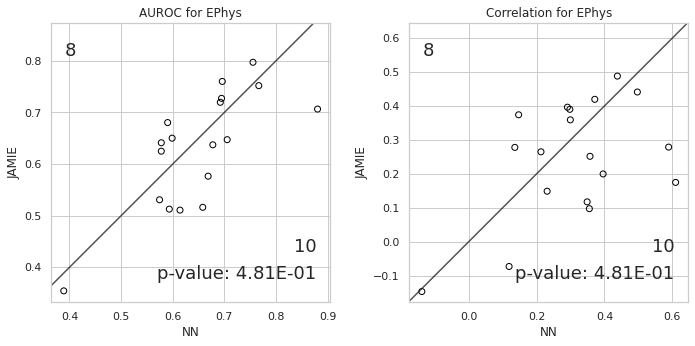

In [18]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

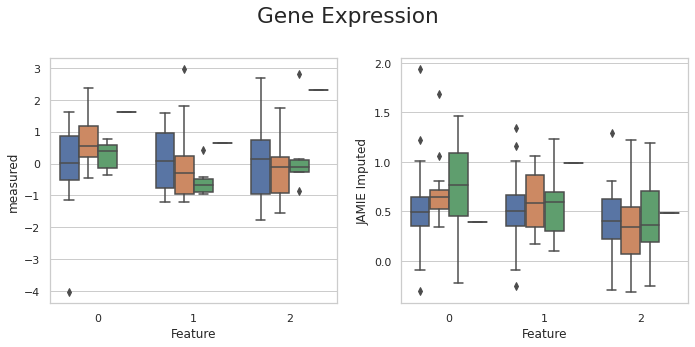

In [19]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], ['measured', 'JAMIE Imputed'], supert=modality_names[0], fnames=2*[features[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

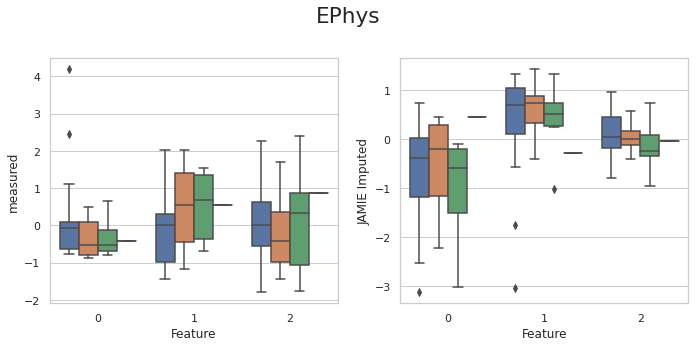

In [20]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], ['measured', 'JAMIE Imputed'], supert=modality_names[1], fnames=2*[features[1]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

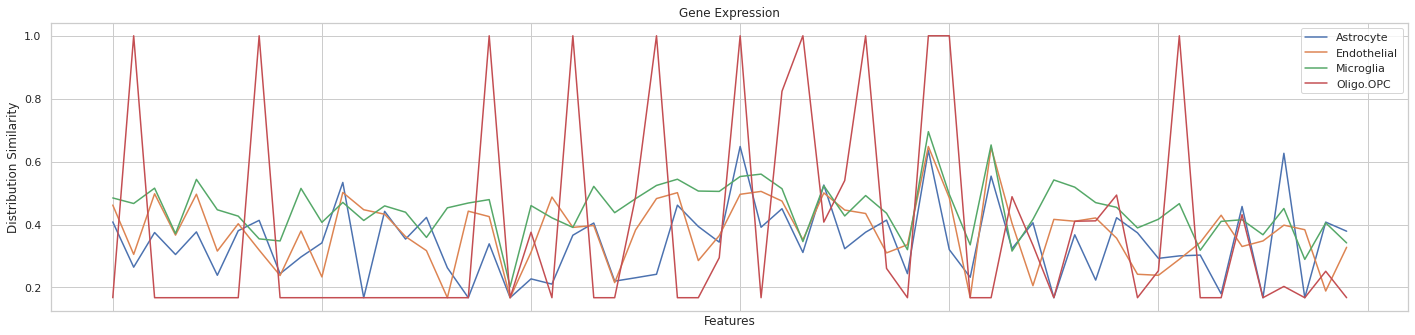

In [21]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png')

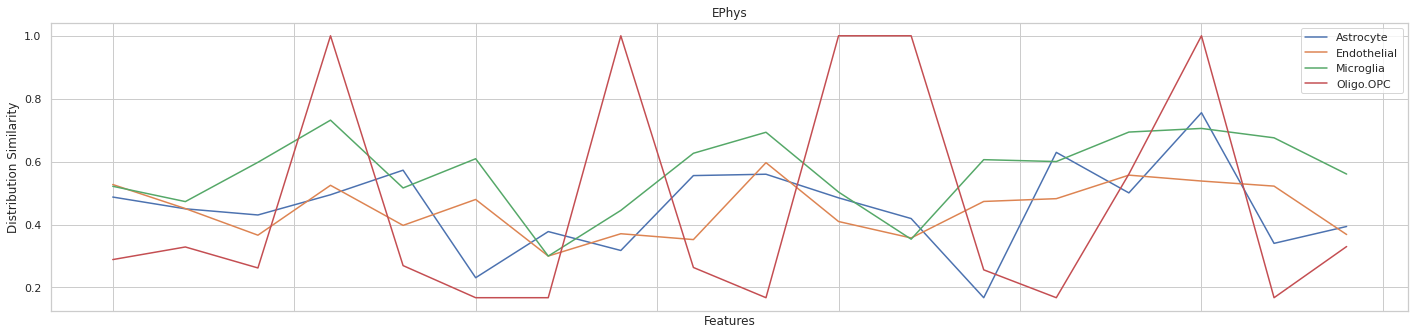

In [22]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png')